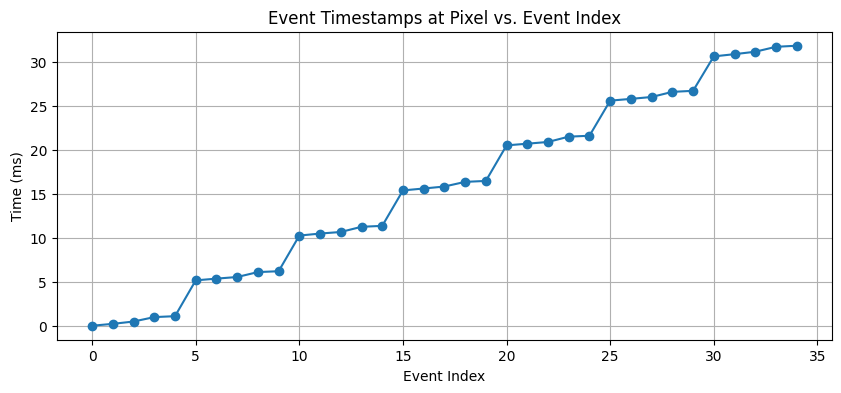

In [10]:
import matplotlib.pyplot as plt
import numpy as np

timestamps = np.array([
    6772257, 6772470, 6772734, 6773237, 6773341,
    6777410, 6777607, 6777791, 6778350, 6778448,
    6782498, 6782727, 6782907, 6783495, 6783602,
    6787629, 6787845, 6788070, 6788599, 6788706,
    6792745, 6792936, 6793133, 6793736, 6793838,
    6797826, 6798028, 6798242, 6798824, 6798943,
    6802855, 6803106, 6803383, 6803943, 6804066
])

# Convert timestamps to relative time (microseconds → milliseconds)
t_rel = (timestamps - timestamps[0]) / 1000.0  # ms

plt.figure(figsize=(10, 4))
plt.plot(t_rel, marker="o")
plt.title("Event Timestamps at Pixel vs. Event Index")
plt.xlabel("Event Index")
plt.ylabel("Time (ms)")
plt.grid(True)
plt.show()


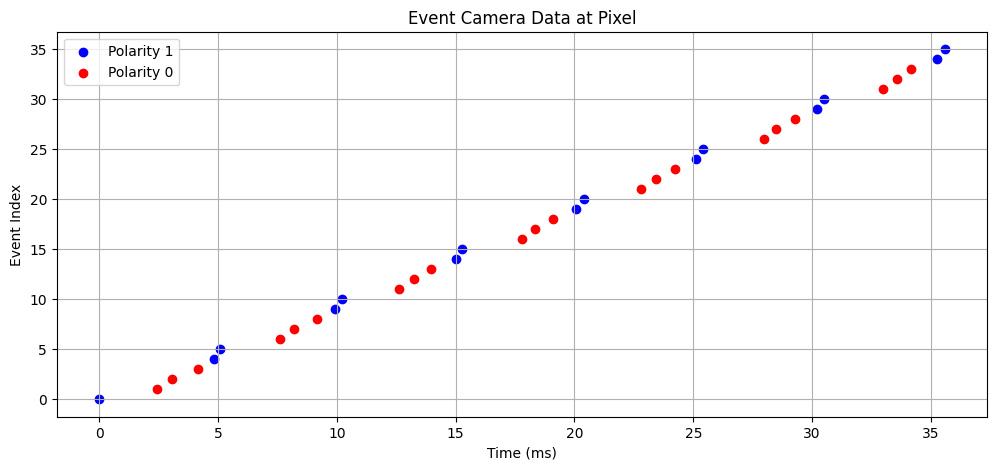

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data: [timestamp, polarity]
data = np.array([
    [8033695, 1],
    [8036116, 0],
    [8036745, 0],
    [8037835, 0],
    [8038507, 1],
    [8038761, 1],
    [8041301, 0],
    [8041882, 0],
    [8042848, 0],
    [8043623, 1],
    [8043928, 1],
    [8046300, 0],
    [8046938, 0],
    [8047654, 0],
    [8048696, 1],
    [8048970, 1],
    [8051498, 0],
    [8052052, 0],
    [8052780, 0],
    [8053768, 1],
    [8054113, 1],
    [8056506, 0],
    [8057142, 0],
    [8057928, 0],
    [8058829, 1],
    [8059088, 1],
    [8061676, 0],
    [8062181, 0],
    [8062983, 0],
    [8063883, 1],
    [8064193, 1],
    [8066699, 0],
    [8067253, 0],
    [8067837, 0],
    [8068954, 1],
    [8069273, 1]
])

timestamps = data[:, 0]
polarities = data[:, 1]
event_index = np.arange(len(timestamps))

# Convert timestamps to milliseconds relative to the first timestamp
time_ms = (timestamps - timestamps[0]) / 1000.0

plt.figure(figsize=(12, 5))
# Blue dots for polarity 1
plt.scatter(time_ms[polarities==1], event_index[polarities==1], color='blue', label='Polarity 1')
# Red dots for polarity 0
plt.scatter(time_ms[polarities==0], event_index[polarities==0], color='red', label='Polarity 0')

plt.title("Event Camera Data at Pixel")
plt.xlabel("Time (ms)")
plt.ylabel("Event Index")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import numpy as np

# Timestamps in microseconds
timestamps = np.array([
    8033695, 8036116, 8036745, 8037835, 8038507,
    8038761, 8041301, 8041882, 8042848, 8043623,
    8043928, 8046300, 8046938, 8047654, 8048696,
    8048970, 8051498, 8052052, 8052780, 8053768,
    8054113, 8056506, 8057142, 8057928, 8058829,
    8059088, 8061676, 8062181, 8062983, 8063883,
    8064193, 8066699, 8067253, 8067837, 8068954,
    8069273
])

polarities = np.array([
    1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,
    1,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1
])

# Extract indices of the first blue dot in each pattern
# For simplicity, pick every 5th event starting from the first blue dot
first_blue_indices = np.where(polarities==1)[0][::2]  # every 2nd blue, since pattern has 2 blues
rotation_timestamps = timestamps[first_blue_indices]

# Convert microseconds to seconds
rotation_timestamps_s = rotation_timestamps / 1e6

# Compute differences between consecutive rotations
periods = np.diff(rotation_timestamps_s) * 2  # multiply by 2 because 2 blades
average_period = np.mean(periods)

# Compute RPM
rpm = 60 / average_period
print(f"Estimated RPM: {rpm:.2f}")


Estimated RPM: 5902.52


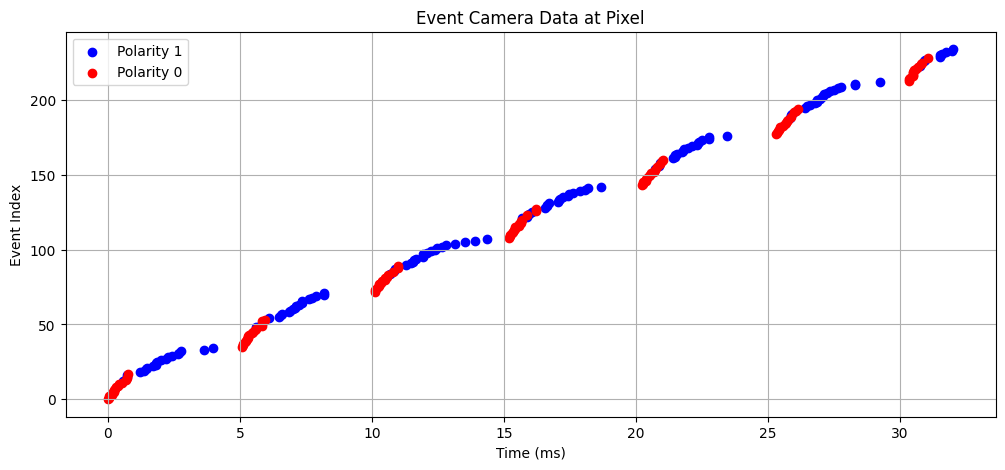

Polarity 0: blade period = 10106.0 µs → RPM = 2968.53
Polarity 1: blade period = 5260.0 µs → RPM = 5703.42

Final RPM (average of polarities): 4335.977798830496


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# ------------------------
# Load data
# ------------------------
data = np.loadtxt("cursor_events_frame152_639_299_3x3.csv")
timestamps = data[:, 0]
polarities = data[:, 1].astype(int)

# Event index (for plotting)
event_index = np.arange(len(timestamps))

# Convert timestamps to milliseconds for plotting
time_ms = (timestamps - timestamps[0]) / 1000.0


# ------------------------
# Plot event data
# ------------------------
plt.figure(figsize=(12, 5))
plt.scatter(time_ms[polarities == 1], event_index[polarities == 1], 
            color='blue',  label='Polarity 1')
plt.scatter(time_ms[polarities == 0], event_index[polarities == 0], 
            color='red',   label='Polarity 0')

plt.title("Event Camera Data at Pixel")
plt.xlabel("Time (ms)")
plt.ylabel("Event Index")
plt.legend()
plt.grid(True)
plt.show()

BLADES = 2

def estimate_period_us(ts):
    """Estimate repeating pattern period using autocorrelation."""
    if len(ts) < 10:
        return None

    dt = np.diff(ts)  # inter-event intervals

    # Remove mean
    x = dt - np.mean(dt)

    # Autocorrelation
    corr = correlate(x, x, mode="full")
    corr = corr[corr.size // 2:]  # keep positive lags

    # Find first significant peak (ignore lag 0)
    peak_idx = np.argmax(corr[1:]) + 1

    # Sum dt up to that point → approximate pattern period
    blade_period_us = np.sum(dt[:peak_idx])
    return blade_period_us


# ----------------------------------------------------
# Process polarity=0 and polarity=1 separately
# ----------------------------------------------------
rpm_results = []
for pol in [0, 1]:
    ts_pol = timestamps[polarities == pol]

    blade_period_us = estimate_period_us(ts_pol)
    if blade_period_us is None:
        continue

    rotation_period_s = (blade_period_us * BLADES) / 1e6
    rpm = 60.0 / rotation_period_s
    rpm_results.append(rpm)

    print(f"Polarity {pol}: blade period = {blade_period_us:.1f} µs → RPM = {rpm:.2f}")


# ----------------------------------------------------
# Final combined RPM
# ----------------------------------------------------
if rpm_results:
    print("\nFinal RPM (average of polarities):", np.mean(rpm_results))
else:
    print("No usable RPM estimate.")

Total duration:        32.015 ms
Bin width:             0.3225 ms
Blade-pass frequency:  186.05 Hz
Rotation frequency:    93.02 Hz
Estimated RPM:         5581.40


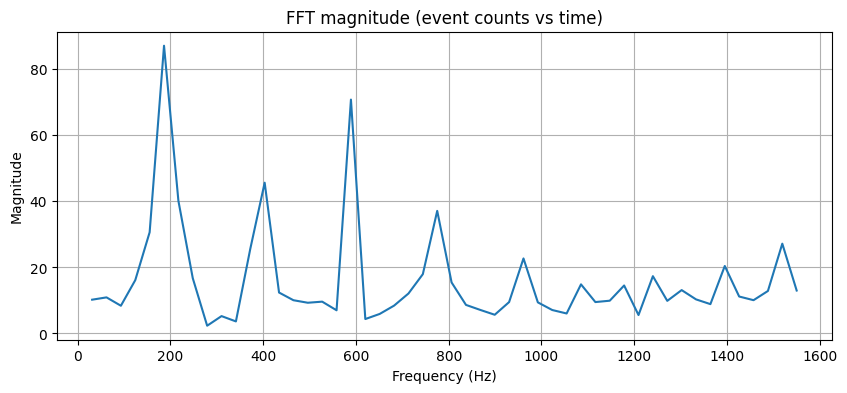

Total duration:        32.015 ms
Bin width:             0.3225 ms
Blade-pass frequency:  186.05 Hz
Rotation frequency:    93.02 Hz
Estimated RPM:         5581.40


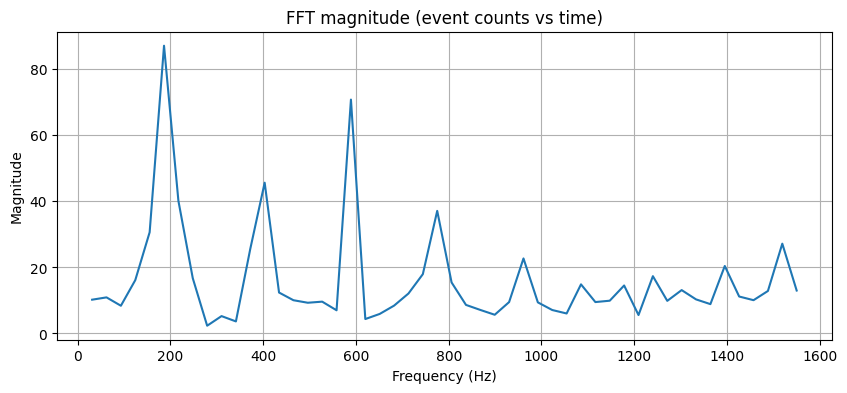

In [27]:
import numpy as np
import matplotlib.pyplot as plt

FILENAME = "cursor_events_frame152_639_299_3x3.csv"
BLADES = 2          # number of blades on the propeller

# ----------------------------------------
# Load data from file
# ----------------------------------------
data = np.loadtxt(FILENAME)
t_us = data[:, 0]                 # timestamps in microseconds
pol  = data[:, 1].astype(int)     # polarities as ints

# Sort in time just in case
order = np.argsort(t_us)
t_us = t_us[order]
pol  = pol[order]

# Convert to relative time in seconds
t = (t_us - t_us[0]) * 1e-6
T_total = t[-1] - t[0]

# ----------------------------------------
# Choose which events to use:
#   mask = np.ones_like(pol, dtype=bool)   # all events
#   mask = (pol == 0)                      # only polarity 0
#   mask = (pol == 1)                      # only polarity 1
# Try all-events first:
mask = np.ones_like(pol == 0, dtype=bool)

t_sel = t[mask]

# ----------------------------------------
# Build time-binned event-count signal
# ----------------------------------------
dt_events = np.diff(t_sel)
median_dt = np.median(dt_events)

# pick bin width: several times median inter-event gap, but not too large
bin_width = max(5 * median_dt, 1e-5)  # at least 10 µs in seconds

nbins = int(np.ceil(T_total / bin_width))
counts, edges = np.histogram(t_sel, bins=nbins, range=(0, T_total))

# subtract mean to remove DC component
x = counts - np.mean(counts)

# ----------------------------------------
# FFT
# ----------------------------------------
X = np.fft.rfft(x)
freqs = np.fft.rfftfreq(len(x), d=bin_width)
mag = np.abs(X)

# ignore zero frequency (DC)
mag[0] = 0.0

# optionally restrict search to a reasonable band (Hz)
f_min, f_max = 5, 5000   # adjust if needed
valid = (freqs >= f_min) & (freqs <= f_max)

peak_idx = np.argmax(mag[valid])
f_bp = freqs[valid][peak_idx]  # blade-pass frequency (Hz)

# Convert to RPM
f_rot = f_bp / BLADES
rpm = 60.0 * f_rot

print(f"Total duration:        {T_total*1000:.3f} ms")
print(f"Bin width:             {bin_width*1000:.4f} ms")
print(f"Blade-pass frequency:  {f_bp:.2f} Hz")
print(f"Rotation frequency:    {f_rot:.2f} Hz")
print(f"Estimated RPM:         {rpm:.2f}")

# ----------------------------------------
# Optional: plot spectrum for sanity check
# ----------------------------------------
plt.figure(figsize=(10,4))
plt.plot(freqs[valid], mag[valid])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT magnitude (event counts vs time)")
plt.grid(True)
plt.show()
import numpy as np
import matplotlib.pyplot as plt

FILENAME = "cursor_events_frame152_639_299_3x3.csv"
BLADES = 2          # number of blades on the propeller

# ----------------------------------------
# Load data from file
# ----------------------------------------
data = np.loadtxt(FILENAME)
t_us = data[:, 0]                 # timestamps in microseconds
pol  = data[:, 1].astype(int)     # polarities as ints

# Sort in time just in case
order = np.argsort(t_us)
t_us = t_us[order]
pol  = pol[order]

# Convert to relative time in seconds
t = (t_us - t_us[0]) * 1e-6
T_total = t[-1] - t[0]

# ----------------------------------------
# Choose which events to use:
#   mask = np.ones_like(pol, dtype=bool)   # all events
#   mask = (pol == 0)                      # only polarity 0
#   mask = (pol == 1)                      # only polarity 1
# Try all-events first:
mask = np.ones_like(pol == 1, dtype=bool)

t_sel = t[mask]

# ----------------------------------------
# Build time-binned event-count signal
# ----------------------------------------
dt_events = np.diff(t_sel)
median_dt = np.median(dt_events)

# pick bin width: several times median inter-event gap, but not too large
bin_width = max(5 * median_dt, 1e-5)  # at least 10 µs in seconds

nbins = int(np.ceil(T_total / bin_width))
counts, edges = np.histogram(t_sel, bins=nbins, range=(0, T_total))

# subtract mean to remove DC component
x = counts - np.mean(counts)

# ----------------------------------------
# FFT
# ----------------------------------------
X = np.fft.rfft(x)
freqs = np.fft.rfftfreq(len(x), d=bin_width)
mag = np.abs(X)

# ignore zero frequency (DC)
mag[0] = 0.0

# optionally restrict search to a reasonable band (Hz)
f_min, f_max = 5, 5000   # adjust if needed
valid = (freqs >= f_min) & (freqs <= f_max)

peak_idx = np.argmax(mag[valid])
f_bp = freqs[valid][peak_idx]  # blade-pass frequency (Hz)

# Convert to RPM
f_rot = f_bp / BLADES
rpm = 60.0 * f_rot

print(f"Total duration:        {T_total*1000:.3f} ms")
print(f"Bin width:             {bin_width*1000:.4f} ms")
print(f"Blade-pass frequency:  {f_bp:.2f} Hz")
print(f"Rotation frequency:    {f_rot:.2f} Hz")
print(f"Estimated RPM:         {rpm:.2f}")

# ----------------------------------------
# Optional: plot spectrum for sanity check
# ----------------------------------------
plt.figure(figsize=(10,4))
plt.plot(freqs[valid], mag[valid])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT magnitude (event counts vs time)")
plt.grid(True)
plt.show()


